In [1]:
# import sys
# !{sys.executable} -m pip install scipy

In [2]:
import json
import numpy as np
from scipy import stats
from collections import Counter 
import matplotlib.pyplot as plt

figsize = (6,4)
pktPayloadSize = 1460 # Bytes

In [3]:
def removeKey(d, key):
    r = dict(d)
    del r[key]
    return r

In [4]:
def mostFrequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0] 

In [5]:
def getPctl(a, p):
    i = int(len(a) * p)
    return a[i]

# Importing the NS3 Simulation Data

In [6]:
workloadName = '_W5'
workloadSource = 'DCTCP'
networkLoad = 0.8
simName = workloadName + '_load-' + str(int(networkLoad*100)) + 'p'
numSim = 8
folderName = str(numSim)+"-parallel-sims-noRtx/"
# folderName = "./"

In [7]:
inboundStatsDict = {}
aggregateStatsDict = {}

for i in range(numSim):
    aggregateStatsDict[i] = {}
    aggregateStatsDict[i]['allTimeStamps'] = [3.0]
    aggregateStatsDict[i]['totNpendingMsgs'] = [0]
    with open(folderName+"MsgTraces"+simName+"_"+str(i)+".tr",'r') as f:
        for line in f:
            msgLog = line.split()

            time = float(msgLog[1])*1e-9        # in seconds
            msgSize = int(msgLog[2])#//1462*1462 # in bytes
            sender = msgLog[3]                  # ip:port
            receiver = msgLog[4]                # ip:port
            txMsgId = int(msgLog[5])

            key = str(i) + ':' + receiver
            senderHost = sender.split(':')[0]

            if (msgLog[0]=='+'):
                if (key in inboundStatsDict):
                    inboundStatsDict[key]['time'].append(time)
                    
                    nPendingMsg = inboundStatsDict[key]['nPendingMsg'][-1] + 1
                    inboundStatsDict[key]['nPendingMsg'].append(nPendingMsg)
                    
                    inboundBytes = inboundStatsDict[key]['inboundBytes'][-1] + msgSize
                    inboundStatsDict[key]['inboundBytes'].append(inboundBytes)
                    
                    inboundStatsDict[key]['pendingSenders'].append(senderHost)
                    
                    pendingSenders =inboundStatsDict[key]['pendingSenders']
                    popSender, nMsg = mostFrequent(pendingSenders)
                    curMaxNMsg = inboundStatsDict[key]['maxNMsgFromSameSender'][-1]
                    if (nMsg > curMaxNMsg):
                        inboundStatsDict[key]['popularSender'].append(popSender)
                    else:
                        curPopSender = inboundStatsDict[key]['popularSender'][-1]
                        inboundStatsDict[key]['popularSender'].append(curPopSender)
                    inboundStatsDict[key]['maxNMsgFromSameSender'].append(nMsg)
                    
                    inboundStatsDict[key]['nDistinctSenders'].append(len(set(pendingSenders)))
                        
                else:
                    inboundStatsDict[key] = {}
                    inboundStatsDict[key]['time'] = [time]
                    inboundStatsDict[key]['nPendingMsg'] = [1]
                    inboundStatsDict[key]['inboundBytes'] = [msgSize]
                    inboundStatsDict[key]['pendingSenders'] = [senderHost]
                    inboundStatsDict[key]['popularSender'] = [senderHost]
                    inboundStatsDict[key]['maxNMsgFromSameSender'] = [1]
                    inboundStatsDict[key]['nDistinctSenders'] = [1]
                    
                aggregateStatsDict[i]['allTimeStamps'].append(time)
                prevNMsgs = aggregateStatsDict[i]['totNpendingMsgs'][-1]
                aggregateStatsDict[i]['totNpendingMsgs'].append(prevNMsgs+1)

            elif (msgLog[0] =='-'):
                assert(key in inboundStatsDict)
                inboundStatsDict[key]['time'].append(time)
                    
                nPendingMsg = inboundStatsDict[key]['nPendingMsg'][-1] - 1
                inboundStatsDict[key]['nPendingMsg'].append(nPendingMsg)
                    
                inboundBytes = inboundStatsDict[key]['inboundBytes'][-1] - msgSize
                inboundStatsDict[key]['inboundBytes'].append(inboundBytes)
                
                inboundStatsDict[key]['pendingSenders'].remove(senderHost)
                
                pendingSenders = inboundStatsDict[key]['pendingSenders']
                if (len(pendingSenders) > 0):
                    popSender, nMsg = mostFrequent(pendingSenders)
                    inboundStatsDict[key]['popularSender'].append(popSender)
                    inboundStatsDict[key]['maxNMsgFromSameSender'].append(nMsg)
                    inboundStatsDict[key]['nDistinctSenders'].append(len(set(pendingSenders)))
                else:
                    inboundStatsDict[key]['popularSender'].append('')
                    inboundStatsDict[key]['maxNMsgFromSameSender'].append(0)
                    inboundStatsDict[key]['nDistinctSenders'].append(0)
                    
                aggregateStatsDict[i]['allTimeStamps'].append(time)
                prevNMsgs = aggregateStatsDict[i]['totNpendingMsgs'][-1]
                aggregateStatsDict[i]['totNpendingMsgs'].append(prevNMsgs-1)

In [8]:
# from itertools import islice
# print (list(islice(inboundStatsDict.items(), 1)))

# Analysis

In [9]:
maxNMsgFromSameSender = []
maxDistinctSenders = []
medDistinctSenders = []
maxPendingMsgs = []
for receiver, stats in inboundStatsDict.items():
    maxNMsgFromSameSender.append(max(stats['maxNMsgFromSameSender']))
    maxDistinctSenders.append(max(stats['nDistinctSenders']))
    medDistinctSenders.append(getPctl(stats['nDistinctSenders'],0.5))
    maxPendingMsgs.append(max(stats['nPendingMsg']))
    
zipData = sorted(zip(maxPendingMsgs,
                     maxDistinctSenders, 
                     medDistinctSenders,
                     maxNMsgFromSameSender))
maxPendingMsgs = np.array([x for x,_,_,_ in zipData])
maxDistinctSenders = np.array([x for _,x,_,_ in zipData])
medDistinctSenders = np.array([x for _,_,x,_ in zipData])
maxNMsgFromSameSender = np.array([x for _,_,_,x in zipData])

# Plotting the Stats

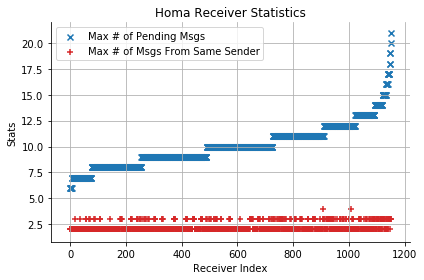

In [10]:
plt.figure(figsize=figsize)
plt.grid()

x = np.arange(len(maxPendingMsgs))

# w = 0.2
# plt.bar(x, maxPendingMsgs, w, label='Max # of Pending Msgs')
# plt.bar(x+w, maxDistinctSenders, w, label='Max # of Distinct Sender')
# plt.bar(x+w*2, medDistinctSenders, w, label='Median # of Distinct Sender')
# plt.bar(x+w*3, maxNMsgFromSameSender, w, label='Max # of Msgs From Same Sender')
# plt.xticks(x + w * 1.5, x)

plt.scatter(x, maxPendingMsgs, label='Max # of Pending Msgs', 
            c='C0', marker='x')
# plt.scatter(x, maxDistinctSenders, label='Max # of Distinct Sender', 
#             c='C1', marker=0)
# plt.scatter(x, medDistinctSenders, label='Median # of Distinct Sender', 
#             c='C2', marker=1)
plt.scatter(x, maxNMsgFromSameSender, label='Max # of Msgs From Same Sender', 
            c='C3', marker='+')

plt.ylabel('Stats')
plt.xlabel('Receiver Index')
plt.title('Homa Receiver Statistics')
plt.legend()

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.tight_layout()

plt.savefig(folderName+'RecvPendingMsgStats'+simName+'.png')
plt.show()

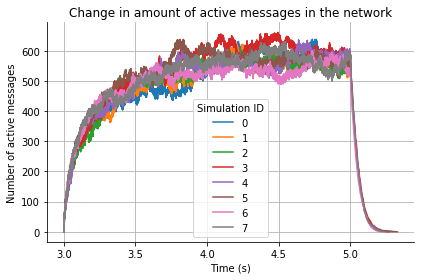

In [11]:
plt.figure(figsize=figsize)
plt.grid()

for simIdx, stats in aggregateStatsDict.items():
    plt.plot(stats['allTimeStamps'], stats['totNpendingMsgs'],
             label = simIdx)

plt.xlabel('Time (s)')
plt.ylabel('Number of active messages')
plt.title('Change in amount of active messages in the network')
plt.legend(title = 'Simulation ID')

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.tight_layout()

plt.savefig(folderName+'TotNActiveMsgs'+simName+'.png')
plt.show()